In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd

In [2]:
df = pd.read_csv('../Data/text_emotion.csv')

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import re

stop = stopwords.words('english')
#df['text'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [4]:
def clean_text(data):
    data=re.sub(r"(#[\d\w\.]+)", '', data)
    data = data.lower()
    data=word_tokenize(data)
    data = ' '.join(data)
    return data

In [5]:
df['text'] = df['content'].apply(clean_text)

In [6]:
classes = sorted(list(set(df['sentiment'])))
no_classes = len(classes)

class_mapping = {}
for idx, name in enumerate(classes):
    class_mapping[name] = idx 

In [7]:
_ = df.pop('tweet_id')
_ = df.pop('author')

In [8]:
df['label'] = df['sentiment'].apply(lambda x : class_mapping[x])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [11]:
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

train_dataset = build_dataset(df_train)
val_dataset = build_dataset(df_val)
test_dataset = build_dataset(df_test)

In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [15]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 13)                221       
Total params: 48,191,637
Trainable params: 48,191,637
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  verbose=1,patience=10,
                                                  mode='max', restore_best_weights=True)

In [18]:
history = model.fit(train_dataset, epochs=50,
                    validation_data=val_dataset,
                    verbose=1,
                   callbacks=[early_stopping])

Epoch 1/50
200/200 [==============================] - 15s 71ms/step - loss: 2.5517 - accuracy: 0.0921 - val_loss: 2.4986 - val_accuracy: 0.1736
Epoch 2/50
200/200 [==============================] - 18s 91ms/step - loss: 2.4334 - accuracy: 0.2085 - val_loss: 2.3559 - val_accuracy: 0.2245
Epoch 3/50
200/200 [==============================] - 22s 112ms/step - loss: 2.2894 - accuracy: 0.2276 - val_loss: 2.2297 - val_accuracy: 0.2349
Epoch 4/50
200/200 [==============================] - 15s 77ms/step - loss: 2.1987 - accuracy: 0.2391 - val_loss: 2.1713 - val_accuracy: 0.2469
Epoch 5/50
200/200 [==============================] - 15s 76ms/step - loss: 2.1577 - accuracy: 0.2525 - val_loss: 2.1407 - val_accuracy: 0.2611
Epoch 6/50
200/200 [==============================] - 15s 74ms/step - loss: 2.1308 - accuracy: 0.2661 - val_loss: 2.1160 - val_accuracy: 0.2751
Epoch 7/50
200/200 [==============================] - 15s 74ms/step - loss: 2.1070 - accuracy: 0.2795 - val_loss: 2.0925 - val_accuracy

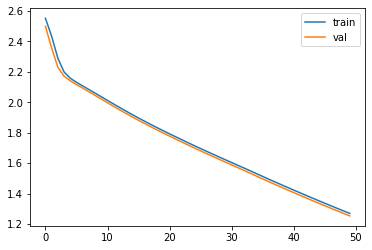

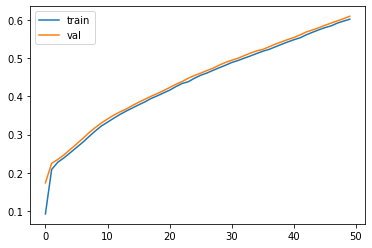

In [19]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tqdm import tqdm

In [21]:
model.evaluate(test_dataset)

63/63 [==============================] - 1s 8ms/step - loss: 2.0588 - accuracy: 0.3309


[2.0588390827178955, 0.3308750092983246]

In [22]:
pred = model.predict(test_dataset)
y_test = list(df_test.label)

In [23]:
import numpy as np

pred_idx = []
target_idx = []

for i in tqdm(range(len(pred))):
    pred_idx.append(np.argmax(pred[i]))
    target_idx.append(y_test[i])

100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 153958.26it/s]


In [24]:
print(classification_report(target_idx, pred_idx, target_names=classes))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        18
     boredom       0.00      0.00      0.00        38
       empty       0.00      0.00      0.00       175
  enthusiasm       0.00      0.00      0.00       151
         fun       0.27      0.03      0.05       335
   happiness       0.32      0.42      0.36      1042
        hate       0.44      0.06      0.10       271
        love       0.38      0.36      0.37       765
     neutral       0.33      0.47      0.38      1704
      relief       0.00      0.00      0.00       304
     sadness       0.29      0.30      0.29      1009
    surprise       0.23      0.03      0.05       427
       worry       0.35      0.46      0.40      1761

    accuracy                           0.33      8000
   macro avg       0.20      0.16      0.15      8000
weighted avg       0.30      0.33      0.30      8000



C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print(confusion_matrix(target_idx, pred_idx))

[[  0   0   0   0   0   1   1   1   5   1   3   0   6]
 [  0   0   0   0   0   2   0   0  12   0  12   0  12]
 [  0   0   0   0   2   9   1   8  83   1  19   2  50]
 [  0   0   0   0   0  24   2  13  66   1  14   0  31]
 [  0   0   0   0   9 101   0  34 103   0  19   4  65]
 [  0   0   0   0   7 433   2 134 255   1  53  10 147]
 [  0   0   0   0   2  10  15   9  53   0  71   1 110]
 [  0   0   0   0   2 218   0 277 131   0  46   4  87]
 [  0   0   0   0   5 245   6  88 793   3 148   9 407]
 [  0   0   0   0   2  80   0  20  96   0  20   2  84]
 [  0   0   0   0   0  60   2  43 219   0 299   5 381]
 [  0   0   0   0   1  74   1  29 150   0  40  13 119]
 [  0   0   0   0   3 114   4  74 456   1 295   6 808]]
